In [1]:
import pandas as pd
import numpy as np
import os
import timeit
import matplotlib.pyplot as plt

pd.set_option('display.max_rows',500)

### Load Data

In [2]:
data_path = '/Users/jujohnson/cms-data/aggregated/partB-2016-minmax-scaled.hdf5'
with pd.HDFStore(data_path) as hdf:
    print(hdf.keys())

['/partB_raw', '/partB_test_normalized', '/partB_train_normalized']


In [3]:
train_df = pd.HDFStore(data_path).get('partB_train_normalized')

In [4]:
train_df.shape

(3753896, 126)

### Select Sample

In [5]:
train_pos = train_df.loc[train_df['exclusion'] == 1]
train_neg = train_df.loc[train_df['exclusion'] == 0]

In [6]:
train_neg_sample = train_neg.sample(frac=0.0575, replace=False)

In [7]:
pos_count = train_pos.shape[0]
neg_count = train_neg_sample.shape[0]
total = pos_count + neg_count
print(f'Positive sample count {pos_count}')
print(f'Negative sample count {neg_count}')
print(f'Minority class size {round(pos_count / total * 100, 3)}%')

Positive sample count 1206
Negative sample count 215780
Minority class size 0.556%


In [8]:
data = train_pos.append(train_neg_sample)

In [9]:
y = data['exclusion']
x = data.drop(columns=['exclusion'])

### Create Train/Test Split

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, stratify=y)

In [12]:
train_pos_cnt = train_y.loc[train_y == 1].shape[0]
train_neg_cnt = train_y.loc[train_y == 0].shape[0]
print(f'Training data imbalance level {train_pos_cnt / (train_pos_cnt + train_neg_cnt) * 100}')

test_pos_cnt = test_y.loc[test_y == 1].shape[0]
test_neg_cnt = test_y.loc[test_y == 0].shape[0]
print(f'Training data imbalance level {test_pos_cnt / (test_pos_cnt + test_neg_cnt) * 100}')

Training data imbalance level 0.5559140032721156
Training data imbalance level 0.5553251301903314


# Random Forest Feature Selection

### Train a Random Forest Model

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
rf_model = RandomForestClassifier(n_jobs=6, n_estimators=100)

In [15]:
start = timeit.default_timer()

rf_model.fit(train_x, train_y)

end = timeit.default_timer()
print(f'Training completed in {end - start} seconds')

Training completed in 17.166769584990107 seconds


### Compute Posterior Class Estimates and Predictions

In [16]:
probabilities = rf_model.predict_proba(test_x)
predictions = rf_model.predict(test_x)

### Evaluate Performance

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
def plot_roc(y_true, y_score):
    roc_auc = roc_auc_score(y_true, y_score)
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

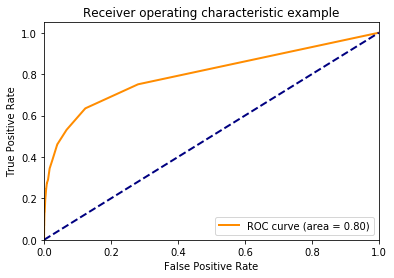

In [173]:
plot_roc(test_y, probabilities[:, 1])

### Inspect Feature Importance

In [184]:
feature_importance_df = pd.DataFrame(zip(train_x.columns, rf_model.feature_importances_))

In [185]:
feature_importance_df.sort_values(by=1, ascending=False, inplace=True)

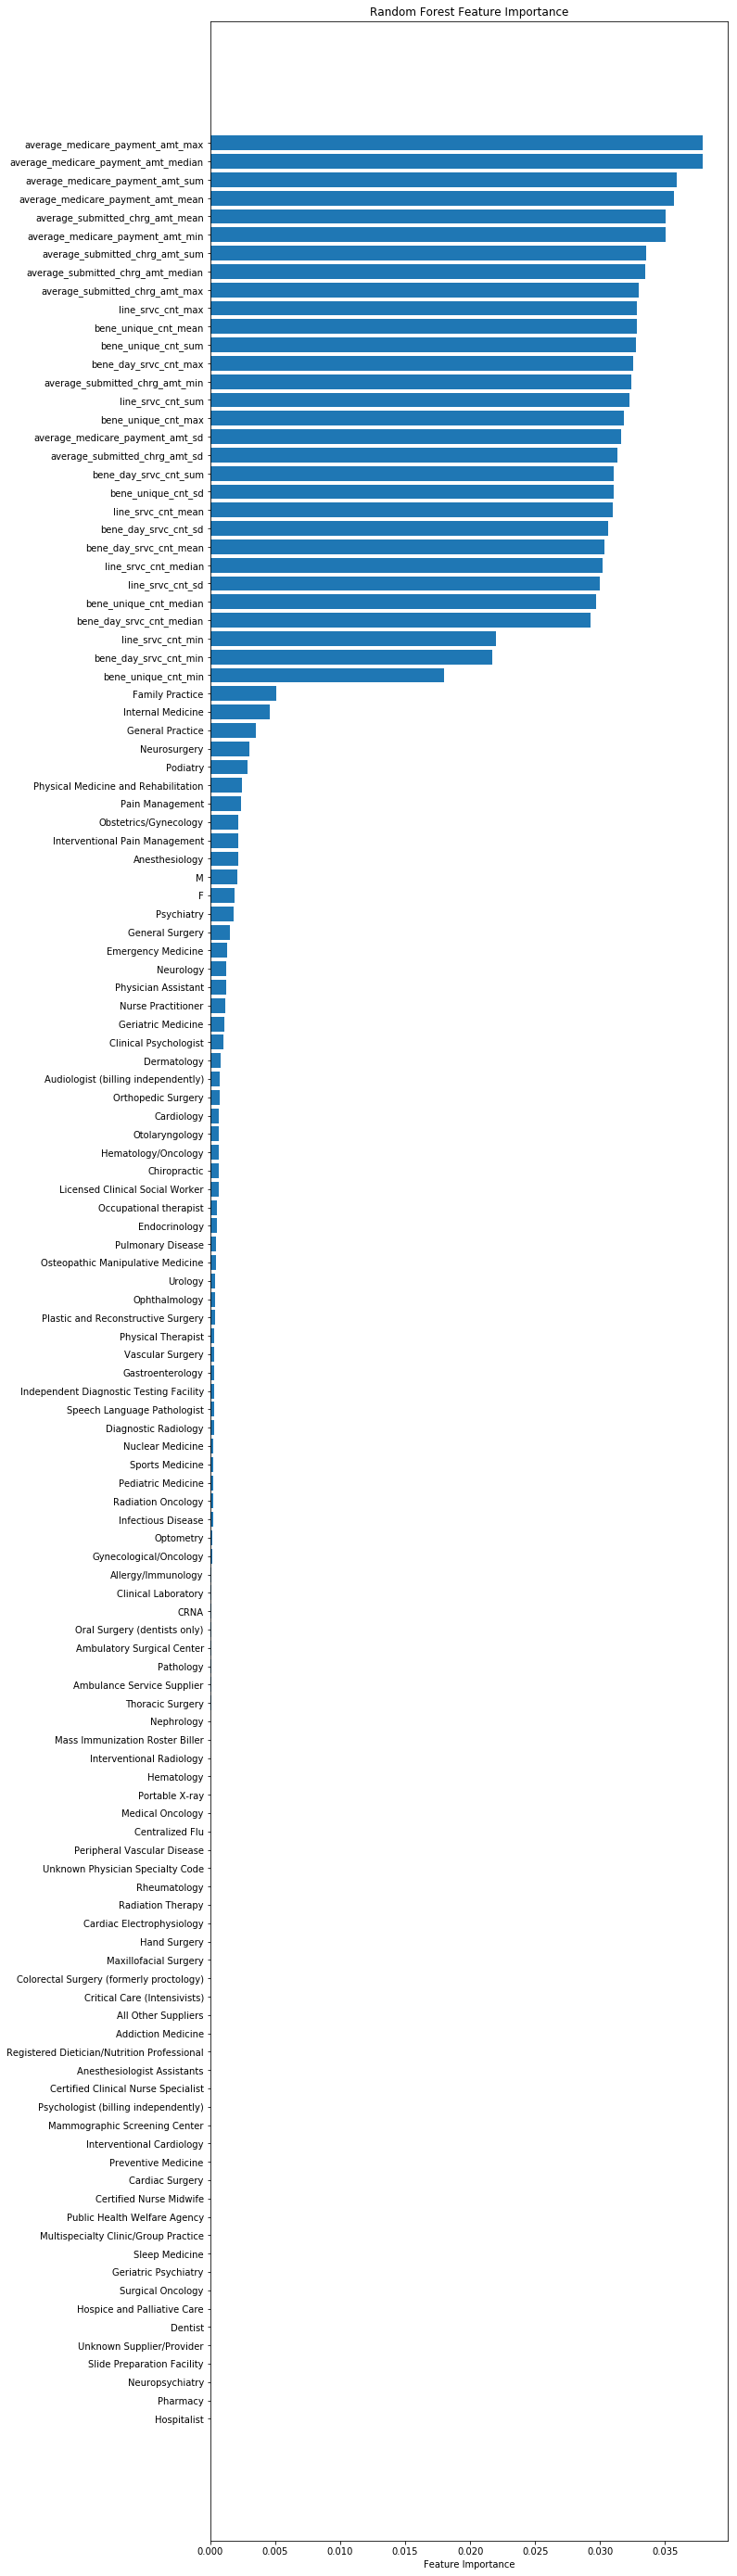

In [186]:
fig, ax = plt.subplots(figsize=(10,50))

ax.barh(feature_importance_df[0], feature_importance_df[1], align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('Random Forest Feature Importance')
plt.show()

In [187]:
rf_top_30_features = feature_importance_df[0][:30]

# Logistic Regression Feature Importance

In [121]:
from sklearn.linear_model import LogisticRegression

In [143]:
lr_model = LogisticRegression(n_jobs=6, max_iter=1000)

In [144]:
start = timeit.default_timer()

lr_model.fit(train_x, train_y)

end = timeit.default_timer()
print(f'Training completed in {end - start} seconds')

/Users/jujohnson/anaconda3/envs/tf.latest/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jujohnson/anaconda3/envs/tf.latest/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Training completed in 1.1394501810000293 seconds


In [145]:
probabilities = lr_model.predict_proba(test_x)
predictions = lr_model.predict(test_x)

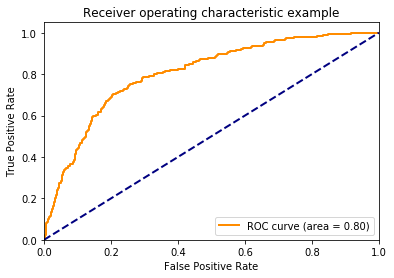

In [146]:
plot_roc(test_y, probabilities[:, 1])

### Inspect Feature Importance

In [188]:
feature_importance_df = pd.DataFrame(zip(train_x.columns, lr_model.coef_[0]))

In [189]:
feature_importance_df.sort_values(by=1, ascending=False, inplace=True)

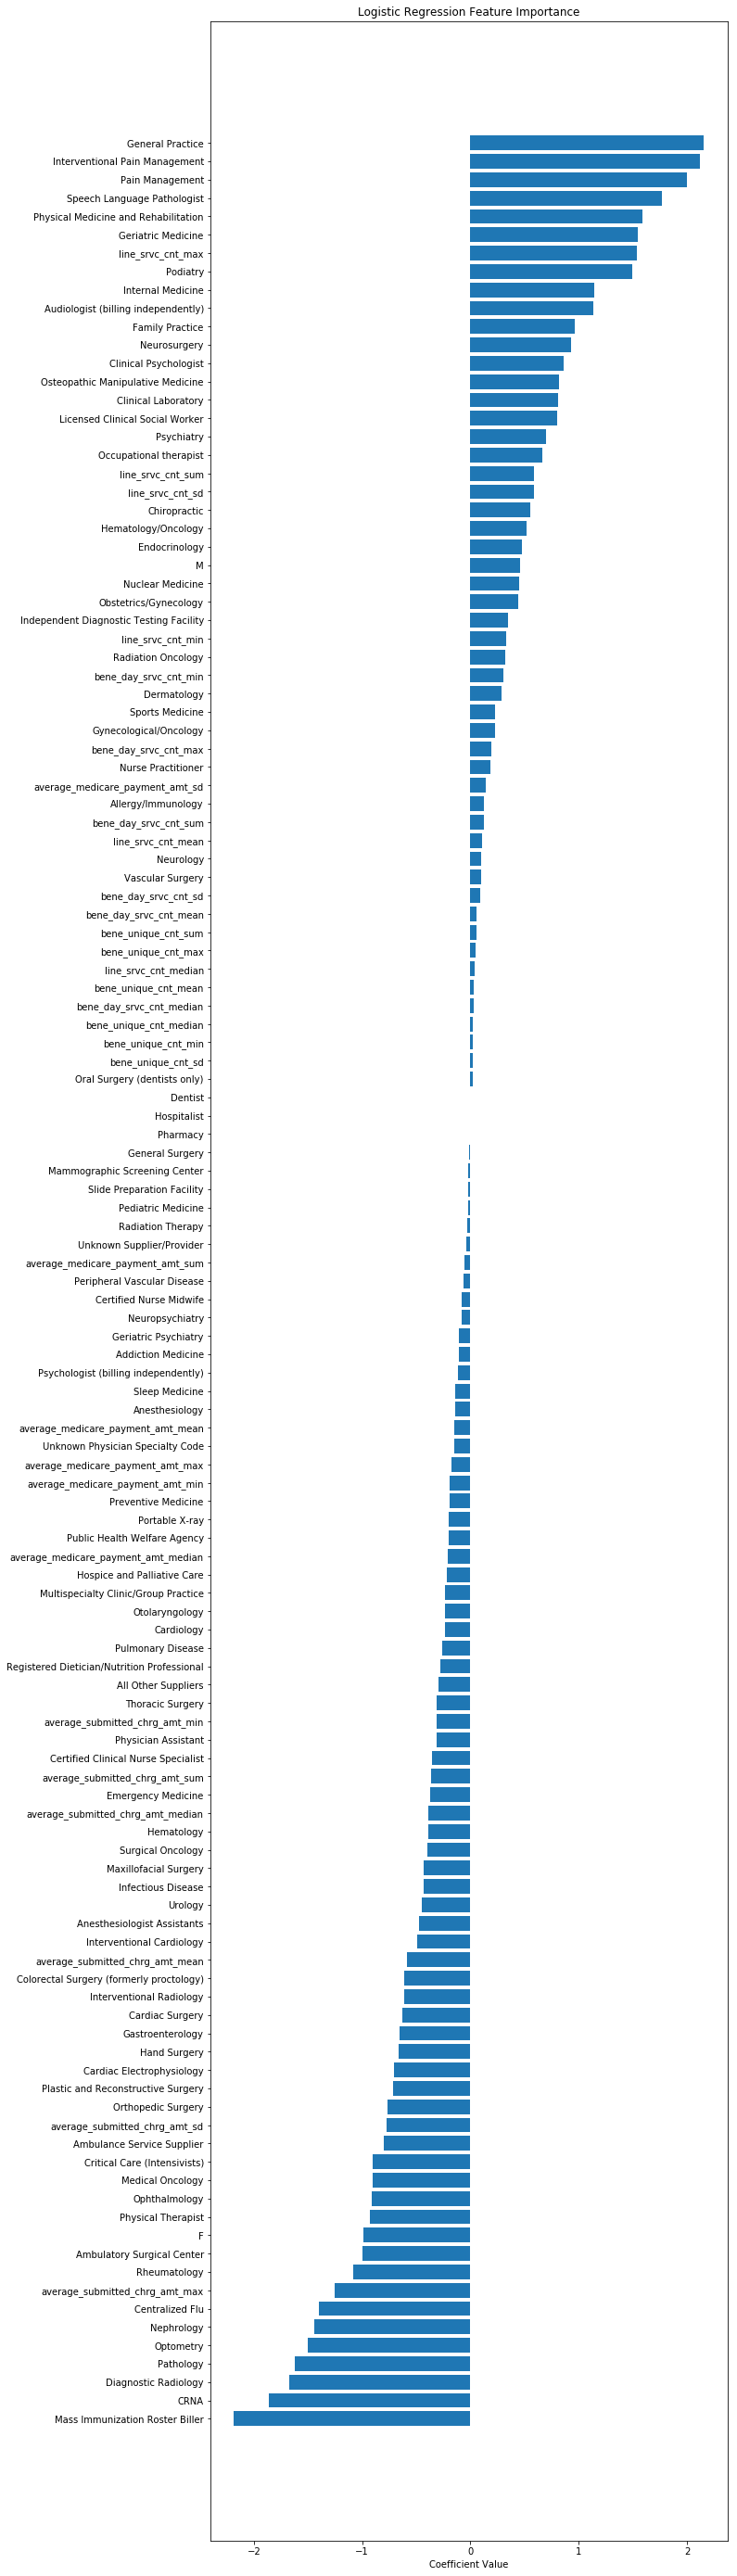

In [190]:
fig, ax = plt.subplots(figsize=(10,50))

ax.barh(feature_importance_df[0], feature_importance_df[1], align='center')
ax.invert_yaxis()
ax.set_xlabel('Coefficient Value')
ax.set_title('Logistic Regression Feature Importance')
plt.show()

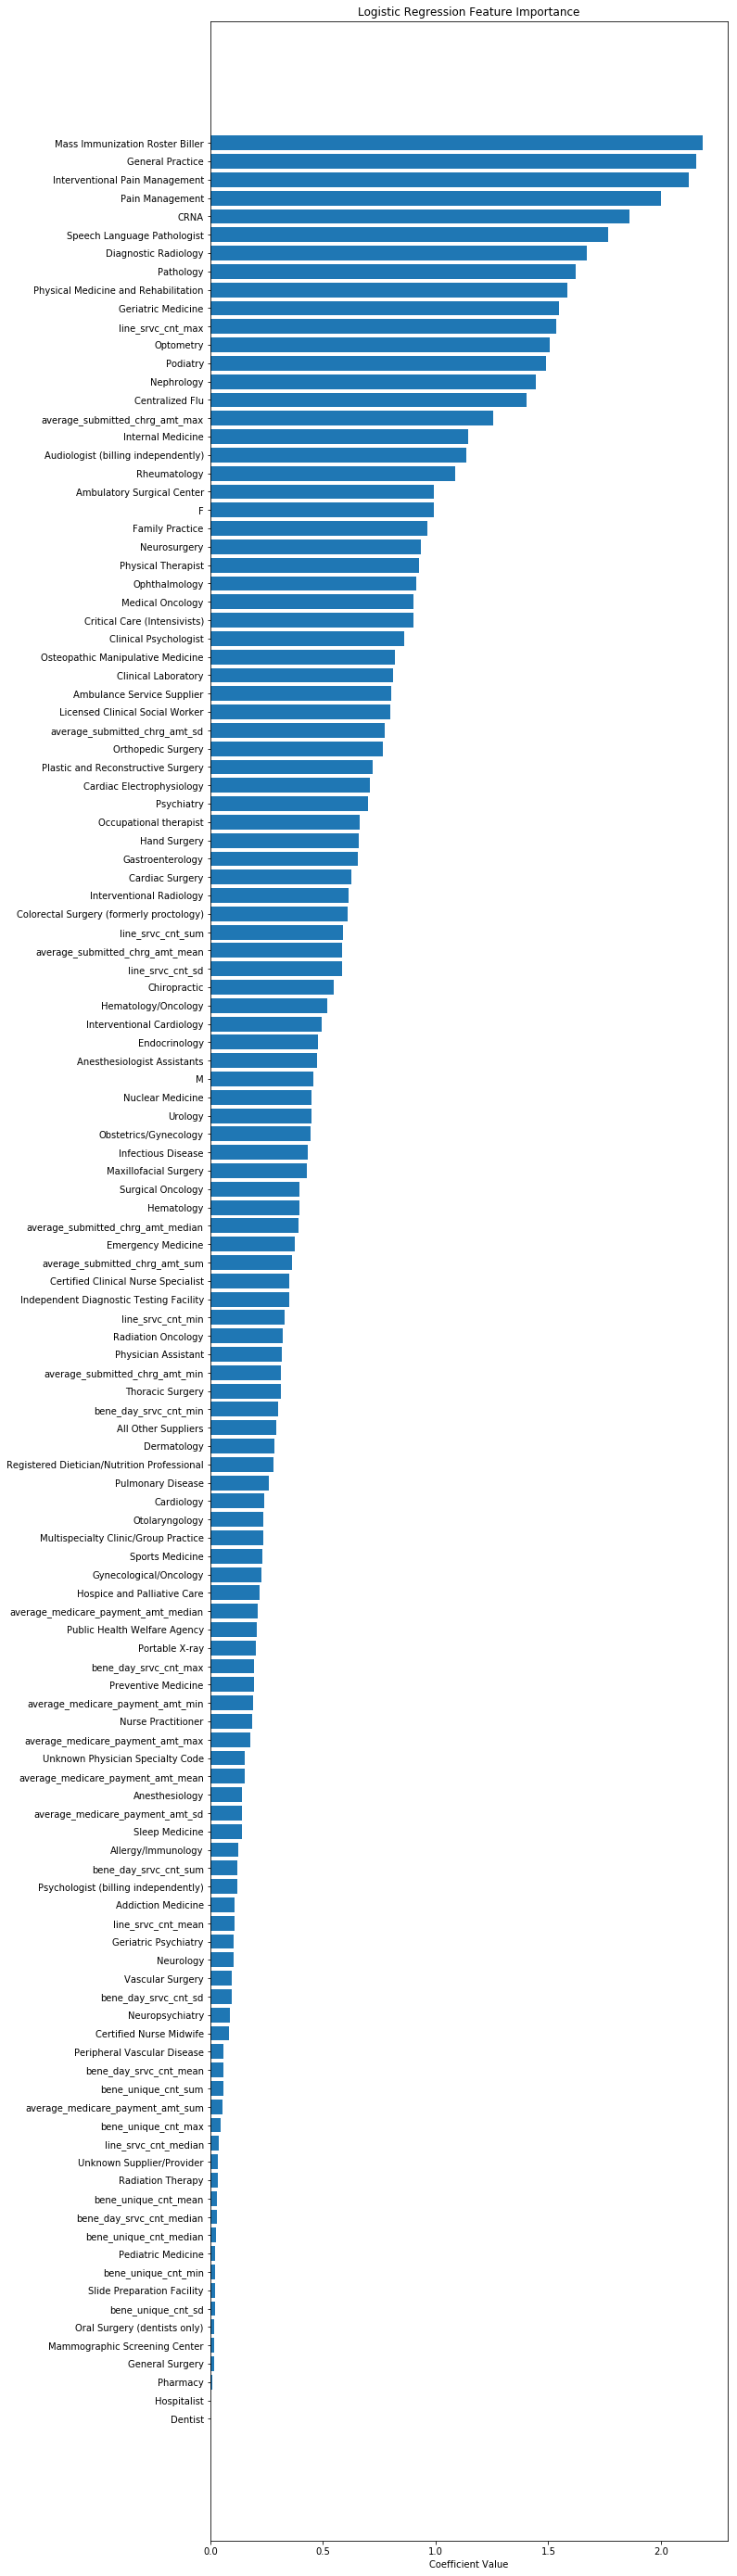

In [191]:
feature_importance_df['absolute_coeff'] = np.absolute(feature_importance_df[1])
feature_importance_df.sort_values(by='absolute_coeff', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,50))

ax.barh(feature_importance_df[0], feature_importance_df['absolute_coeff'], align='center')
ax.invert_yaxis()
ax.set_xlabel('Coefficient Value')
ax.set_title('Logistic Regression Feature Importance')
plt.show()

In [192]:
lr_top_30_features = feature_importance_df[0][:30]

### Comparing RF to LR Feature Selection

In [193]:
lr_top_30_dict = { key: True for key in lr_top_30_features }
rf_top_30_dict = { key: True for key in rf_top_30_features }

In [194]:
matching_features = [x for x in lr_top_30_features if rf_top_30_dict.get(x) != None]

In [195]:
# only two match
matching_features

['line_srvc_cnt_max', 'average_submitted_chrg_amt_max']

# Chi-Squared

In [196]:
from sklearn.feature_selection import SelectKBest, chi2, 

In [206]:
chi, pvals = chi2(train_x, train_y)

In [208]:
feature_importance_df = pd.DataFrame(zip(train_x.columns, chi))

In [211]:
feature_importance_df.sort_values(by=1, ascending=False, inplace=True)

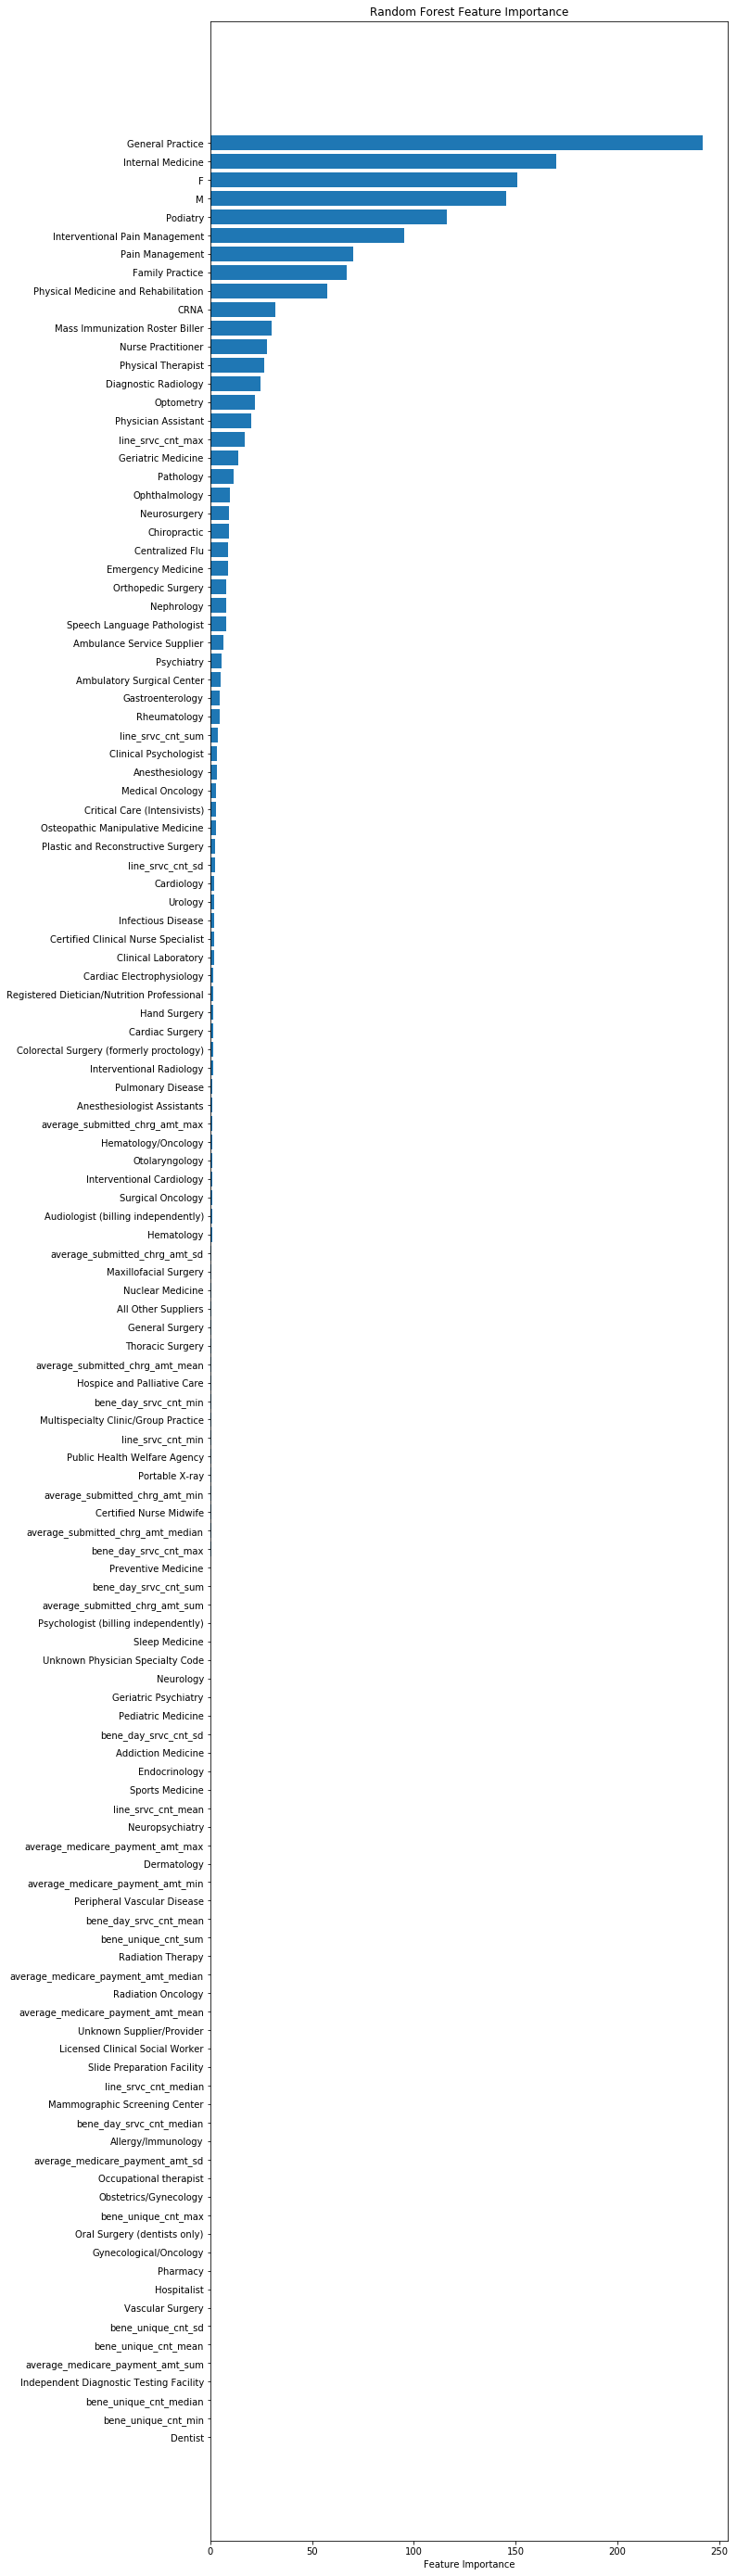

In [214]:
fig, ax = plt.subplots(figsize=(10,50))

ax.barh(feature_importance_df[0], feature_importance_df[1], align='center')
ax.invert_yaxis()
ax.set_xlabel('Feature Importance')
ax.set_title('Random Forest Feature Importance')
plt.show()